### K-Means Clustering

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [142]:
df = pd.read_csv("dataset/Mall_customers.csv")

In [143]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [145]:
unique = df['Gender'].unique()
to_int = {date: i for i, date in enumerate(unique)}
df['Gender'] = df['Gender'].map(to_int)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [147]:
df_train = df.iloc[:150 , :]

In [148]:
df_train

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40
...,...,...,...,...,...
145,146,0,28,77,97
146,147,0,48,77,36
147,148,1,32,77,74
148,149,1,34,78,22


In [195]:
X = df_train.iloc[:, 3:5].values

In [196]:
X_df = df_train
X_df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40
...,...,...,...,...,...
145,146,0,28,77,97
146,147,0,48,77,36
147,148,1,32,77,74
148,149,1,34,78,22


In [197]:
# def train_test_split(X, test_size=0.3):
#     split_index = int((1 - test_size) * len(X))
#     return X[:split_index], X[split_index:]

# X_train, X_test = train_test_split(X)

In [198]:
centroids_coordinates = []

In [199]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, random_state=None, init='k-means++'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.init = init

    def _initialize_centroids_kmeans_pp(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        centroids = np.empty((self.n_clusters, n_features), dtype=X.dtype)
        first_idx = np.random.choice(n_samples)
        centroids[0] = X[first_idx]
        
        closest_dist_sq = np.full(n_samples, np.inf)
        
        for c_id in range(1, self.n_clusters):
            dist_to_new_centroid = np.linalg.norm(X - centroids[c_id-1], axis=1) ** 2
            closest_dist_sq = np.minimum(closest_dist_sq, dist_to_new_centroid)
            
            probabilities = closest_dist_sq / closest_dist_sq.sum()
            next_idx = np.random.choice(n_samples, p=probabilities)
            centroids[c_id] = X[next_idx]
        
        return centroids

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
    
        self._store_X(X)  # store X for inertia
    
        np.random.seed(self.random_state)
        
        if self.init == 'k-means++':
            self.centroids = self._initialize_centroids_kmeans_pp(X)
        else:
            initial_centroid_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.centroids = X[initial_centroid_indices]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            new_centroids = np.array([
                X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 else self.centroids[i]
                for i in range(self.n_clusters)
            ])

            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            
            self.centroids = new_centroids
        
        self.labels_ = labels

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

    def cluster_centers_(self):
        return self.centroids

    @property
    def inertia_(self):
        if self.centroids is None or self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")
        wcss = 0.0
        for i in range(self.n_clusters):
            cluster_points = self.X[self.labels_ == i]
            if len(cluster_points) > 0:
                distances = np.linalg.norm(cluster_points - self.centroids[i], axis=1)
                wcss += np.sum(distances ** 2)
        return wcss

    def _store_X(self, X):
        # Internal helper to store X for inertia calculation
        self.X = X


In [200]:
wcss = []

for i in range(1, 10):
    kmeans = ManualKMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    print(f'Clusters: {i}, WCSS: {kmeans.inertia_}')
    wcss.append(kmeans.inertia_)

Clusters: 1, WCSS: 128309.20000000001
Clusters: 2, WCSS: 84549.3167464115
Clusters: 3, WCSS: 54055.21430019255
Clusters: 4, WCSS: 34756.099930986886
Clusters: 5, WCSS: 20482.478036456298
Clusters: 6, WCSS: 16909.658614358614
Clusters: 7, WCSS: 15163.139688246216
Clusters: 8, WCSS: 10740.543345543345
Clusters: 9, WCSS: 8874.804806468042


In [201]:
wcss

[128309.20000000001,
 84549.3167464115,
 54055.21430019255,
 34756.099930986886,
 20482.478036456298,
 16909.658614358614,
 15163.139688246216,
 10740.543345543345,
 8874.804806468042]

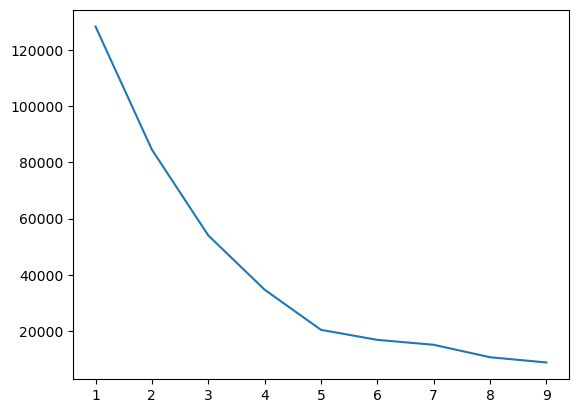

In [202]:
plt.plot(range(1, 10), wcss)
plt.show()

In [203]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
kmeans.fit(X)

In [204]:
print(kmeans.cluster_centers_())

[[73.35714286 82.71428571]
 [73.69230769 19.61538462]
 [24.58333333  9.58333333]
 [55.36486486 50.40540541]
 [25.72727273 79.36363636]
 [31.53333333 35.86666667]]


In [205]:
y_train = kmeans.predict(X)

In [206]:
y_train

array([5, 4, 2, 4, 5, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 5, 4, 5, 4, 5, 4,
       2, 4, 2, 4, 5, 4, 5, 4, 2, 4, 2, 4, 2, 4, 2, 4, 5, 4, 5, 4, 5, 3,
       5, 4, 3, 5, 5, 5, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [207]:
output = pd.DataFrame(y_train, columns = ['Cluster Number'])
output

,Cluster Number
0,5
1,4
2,2
3,4
4,5
...,...
145,0
146,1
147,0
148,1


In [208]:
new_df = pd.concat([X_df, output], axis = 1)
new_df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster Number
0,1,0,19,15,39,5
1,2,0,21,15,81,4
2,3,1,20,16,6,2
3,4,1,23,16,77,4
4,5,1,31,17,40,5
...,...,...,...,...,...,...
145,146,0,28,77,97,0
146,147,0,48,77,36,1
147,148,1,32,77,74,0
148,149,1,34,78,22,1


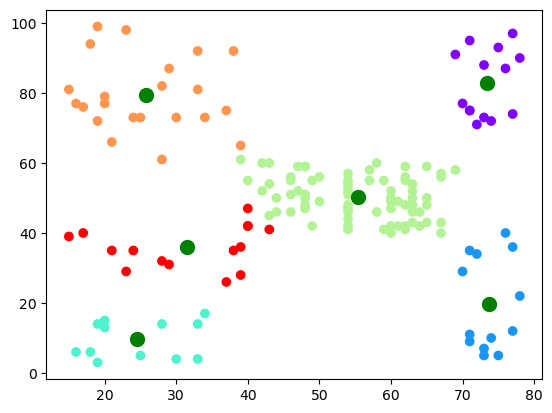

In [214]:
plt.scatter(X[:, 0], X[:, 1], c = y_train, cmap = 'rainbow')
plt.scatter(kmeans.cluster_centers_()[:, 0], kmeans.cluster_centers_()[:, 1], s = 100, c = 'green')
plt.show()

In [215]:
X_test = df.iloc[150: , :].values
X_test

array([[151,   0,  43,  78,  17],
       [152,   0,  39,  78,  88],
       [153,   1,  44,  78,  20],
       [154,   1,  38,  78,  76],
       [155,   1,  47,  78,  16],
       [156,   1,  27,  78,  89],
       [157,   0,  37,  78,   1],
       [158,   1,  30,  78,  78],
       [159,   0,  34,  78,   1],
       [160,   1,  30,  78,  73],
       [161,   1,  56,  79,  35],
       [162,   1,  29,  79,  83],
       [163,   0,  19,  81,   5],
       [164,   1,  31,  81,  93],
       [165,   0,  50,  85,  26],
       [166,   1,  36,  85,  75],
       [167,   0,  42,  86,  20],
       [168,   1,  33,  86,  95],
       [169,   1,  36,  87,  27],
       [170,   0,  32,  87,  63],
       [171,   0,  40,  87,  13],
       [172,   0,  28,  87,  75],
       [173,   0,  36,  87,  10],
       [174,   0,  36,  87,  92],
       [175,   1,  52,  88,  13],
       [176,   1,  30,  88,  86],
       [177,   0,  58,  88,  15],
       [178,   0,  27,  88,  69],
       [179,   0,  59,  93,  14],
       [180,  

In [216]:
X_test = X_test[:, 3:5]
X_test


array([[ 78,  17],
       [ 78,  88],
       [ 78,  20],
       [ 78,  76],
       [ 78,  16],
       [ 78,  89],
       [ 78,   1],
       [ 78,  78],
       [ 78,   1],
       [ 78,  73],
       [ 79,  35],
       [ 79,  83],
       [ 81,   5],
       [ 81,  93],
       [ 85,  26],
       [ 85,  75],
       [ 86,  20],
       [ 86,  95],
       [ 87,  27],
       [ 87,  63],
       [ 87,  13],
       [ 87,  75],
       [ 87,  10],
       [ 87,  92],
       [ 88,  13],
       [ 88,  86],
       [ 88,  15],
       [ 88,  69],
       [ 93,  14],
       [ 93,  90],
       [ 97,  32],
       [ 97,  86],
       [ 98,  15],
       [ 98,  88],
       [ 99,  39],
       [ 99,  97],
       [101,  24],
       [101,  68],
       [103,  17],
       [103,  85],
       [103,  23],
       [103,  69],
       [113,   8],
       [113,  91],
       [120,  16],
       [120,  79],
       [126,  28],
       [126,  74],
       [137,  18],
       [137,  83]], dtype=int64)

In [217]:
y_pred = kmeans.predict(X_test)

In [218]:
y_pred

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0], dtype=int64)